# Sentiment analysis

In this notebook we perform sentiment analysis on the preprocessed Food.com dataset using a variety of NLP models.

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from transformers import pipeline
from tqdm import tqdm
from collections import Counter
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
tqdm.pandas()

In [ ]:
pd.set_option('display.max_colwidth',None)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

In [3]:
df_full = pd.read_pickle('preprocessed_dataset.pkl')

In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   user_id            1132367 non-null  int64         
 1   recipe_id          1132367 non-null  int64         
 2   date               1132367 non-null  datetime64[ns]
 3   rating             1132367 non-null  int64         
 4   minutes            1132367 non-null  int64         
 5   contributor_id     1132367 non-null  int64         
 6   submitted          1132367 non-null  datetime64[ns]
 7   nutrition          1132367 non-null  object        
 8   n_steps            1132367 non-null  int64         
 9   n_ingredients      1132367 non-null  int64         
 10  plain_review       1132367 non-null  object        
 11  plain_tags         1132367 non-null  object        
 12  plain_name         1132367 non-null  object        
 13  plain_description  1132367 

In [5]:
df_full.head()

,user_id,recipe_id,date,rating,minutes,contributor_id,submitted,nutrition,n_steps,n_ingredients,plain_review,plain_tags,plain_name,plain_description,plain_ingredients,review,nostop_review
0,38094,40893,2003-02-17,4,495,1533,2002-09-21,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,9,"[great, salad, cooked, top, stove, 15, minutesadded, shake, cayenne, pinch, salt, used, low, fat, sour, cream, thanks]","[weeknight, time-to-make, course, main-ingredient, preparation, occasion, soups-stews, beans, vegetables, easy, crock-pot-slow-cooker, dietary, equipment]","[white, bean, green, chile, pepper, soup]","[easy, soup, crockpot]","[great, northern, beans, yellow, onion, diced, green, chilies, ground, cumin, garlic, powder, fat-free, chicken, broth, fresh, cilantro, leaves, extra, virgin, olive, oil, sour, cream]",Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.,great salad. cooked top stove 15 minutes.added shake cayenne pinch salt. used low fat sour cream. thanks.
1,1293707,40893,2011-12-21,5,495,1533,2002-09-21,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,9,"[simple, delicious, great, chilly, fall, evening, doubled, <br/><br/>second, time, around, forgot, remaining, cumin, usually, love, cumin, didn't, notice, missing, 1/2, teaspoon]","[weeknight, time-to-make, course, main-ingredient, preparation, occasion, soups-stews, beans, vegetables, easy, crock-pot-slow-cooker, dietary, equipment]","[white, bean, green, chile, pepper, soup]","[easy, soup, crockpot]","[great, northern, beans, yellow, onion, diced, green, chilies, ground, cumin, garlic, powder, fat-free, chicken, broth, fresh, cilantro, leaves, extra, virgin, olive, oil, sour, cream]","So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!","simple, delicious! great chilly fall evening. doubled ;)<br/><br/>second time around, forgot remaining cumin. usually love cumin, didn't notice missing 1/2 teaspoon!"
2,8937,44394,2002-12-01,4,20,56824,2002-10-27,"[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]",5,4,"[worked, well, easy, used, quite, whole, package, 10oz, white, chips, great]","[30-minutes-or-less, time-to-make, course, main-ingredient, preparation, occasion, for-large-groups, 5-ingredients-or-less, drop-cookies, desserts, lunch, oven, easy, potluck, fall, finger-food, heirloom-historical, holiday-event, kid-friendly, picnic, spring, summer, winter, cakes, cookies-and-brownies, easter, chocolate, dietary, gifts, christmas, hanukkah, new-years, seasonal, comfort-food, independence-day, ramadan, rosh-hashana, valentines-day, taste-mood, to-go, equipment, number-of-servings, presentation]","[devilicious, cookie, cake, delights]",[nan],"[""devils, food, cake, mix"", vegetable, oil, eggs, ""reeses, pieces""]",This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!,worked well easy. used quite whole package (10oz) white chips. great!
3,126440,85009,2010-02-27,5,10,64342,2004-02-25,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,13,"[made, mexican, topping, took, bunko, everyone, loved, it]","[15-minutes-or-less, time-to-make, course, main-ingredient, preparation, condiments-etc, vegetables, easy, inexpensive, number-of-servings, 3-steps-or-less]","[baked, potato, toppings]","[toppings, sure, makes, nice, change, plain, old, sour, cream, bacon, bitsyou, use, regular, light, fat, free, calorie, reduced, mayonnaise]","[mayonnaise, salsa, cheddar, cheese, refried, beans, ham, green, pepper, tomatoes, cooked, bacon, pepperoni, mozzarella, cheese, parmesan, cheese, pizza, sauce, frozen, chopped, broccoli]",I made the Mexican topping and took it to bunko. Everyone loved it.,made mexican topping took bunko. everyone loved it.
4,57222,85009,2011-10-01,5,10,64342,2004-02-25,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.

Let's try one simple model called TextBlob, which is a lexicon-based sentiment analyser. This means that it assigns a score (positive, towards +1, for more positive texts; negative, towards -1, for more negative texts; 0 for neutral texts) to individual words in the text and then combines them into an overall score. We perform the analysis using both the complete reviews and the reviews without stopwords.

In [10]:
df_full['sentiment_1'] = df_full.review.astype(str).apply(lambda text: TextBlob(text).sentiment[0])

In [11]:
df_full['sentiment_2'] = df_full.nostop_review.astype(str).apply(lambda text: TextBlob(text).sentiment[0])

As we see in the following, the results of TextBlob on the two different formats of reviews are generally fairly similar. However, we clearly see that some results are off (e.g., the rwviews with id equal to 7, 10, 11). This is maybe related to the fact that just the presence of certain words in the text can greatly impact the result of the model, because it does not take into consideration the relation between adjacent words, which in turn can greatly affect their meaning. 

In [10]:
df_full[['review','sentiment_1','sentiment_2']].head(20)

,review,sentiment_1,sentiment_2
0,Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.,0.27,0.27
1,"So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!",0.24,0.24
2,This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!,0.37,0.41
3,I made the Mexican topping and took it to bunko. Everyone loved it.,0.35,0.35
4,"Made the cheddar bacon topping, adding a sprinkling of black pepper. Yum!",-0.21,-0.21
5,very very sweet. after i waited the 2 days i bought 2 more pints of raspberries and added them to the mix. i'm going to add some as a cake filling today and will take a photo.,0.48,0.35
6,"Just an observation, so I will not rate. I followed this procedure with strawberries instead of raspberries. Perhaps this is the reason it did not work well. Sorry to report that the strawberries I did in August were moldy in October. They were stored in my downstairs fridge, which is very cold and infrequently opened. Delicious and fresh-tasting prior to that, though. So, keep a sharp eye on them. Personally I would not keep them longer than a month. This recipe also appears as #120345 posted in July 2009, which is when I tried it. I also own the Edna Lewis cookbook in which this appears.",0.03,-0.04
7,"This recipe was OVERLY too sweet. I would start out with 1/3 or 1/4 cup of sugar and jsut add on from there. Just 2 cups was way too much and I had to go back to the grocery store to buy more raspberries because it made so much mix. Overall, I would but the long narrow box or raspberries. Its a perfect fit for the recipe plus a little extra. I was not impressed with this recipe. It was exceptionally over-sweet. If you make this simple recipe, MAKE SURE TO ADD LESS SUGAR!",0.16,0.23
8,Very good!,1.00,0.88
9,Better than the real!!,0.41,0.41


For this reason, we try more elaborate models, specifically those based on transformers, which represent the state of the art in NLP. Given than these models are extremely complex, we use some pre-trained models made available by Hugging Face: https://huggingface.co/models?language=en&library=tf&pipeline_tag=text-classification&sort=downloads&search=sentiment.

In [19]:
sentiment_pipeline = pipeline('sentiment-analysis')
#sentiment_pipeline = pipeline(model='finiteautomata/bertweet-base-sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

In [20]:
sentiment_pipeline(df_full.nostop_review[7])

[{'label': 'NEGATIVE', 'score': 0.9475618600845337}]

Since the transformer model is quite complex and the dataset contains a huge number of reviews, we can select a smaller subsample.

In [26]:
df_subset = df_full.sample(10000)

In [49]:
df_subset['sentiment_3'] = df_subset.review.astype(str).progress_apply(lambda text: sentiment_pipeline(text[:500]))

100%|██████████| 10000/10000 [30:03<00:00,  5.54it/s]


In [ ]:
df_subset.to_pickle('sentiment_dataset.pkl')

In [2]:
df_subset = pd.read_pickle('sentiment_dataset.pkl')

Let's visualise the distribution of the reviews sentiments according to the different models. As we see, the transformer model predicts a much more polarised setting, where most reviews are extremely positive and the second most frequent case is that of extremely negative reviews. This is in agreement to what was shown in the notebook <code>preprocess_dataset.ipynb</code>, where the distribution of ratings showed a similarly polarised view of the recipes. On the other hand, the TextBlob model uncorrectly sees most reviews as slightly positive.

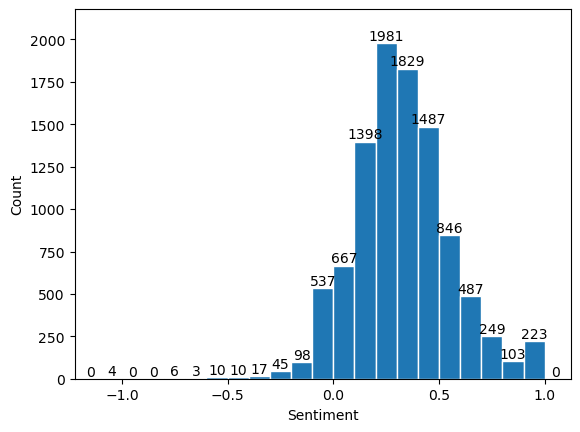

In [4]:
values, bins, bars = plt.hist(df_subset['sentiment_1'],bins=np.arange(-1.2,1.2,0.1),edgecolor='white')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.bar_label(bars, fontsize=10)
plt.margins(x=0.01, y=0.1)
plt.show()

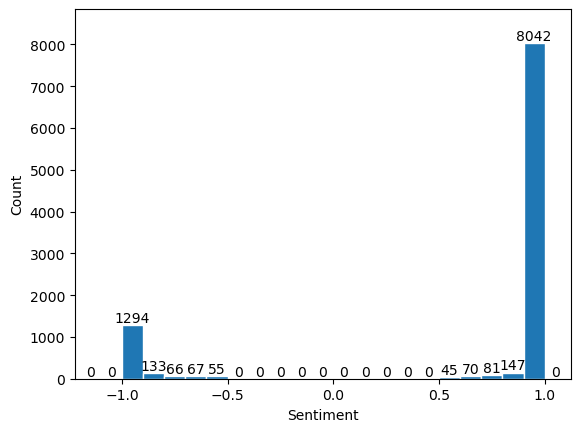

In [5]:
sent_3 = [df_subset['sentiment_3'].iloc[i][0]['score'] if df_subset['sentiment_3'].iloc[i][0]['label']=='POSITIVE' else -df_subset['sentiment_3'].iloc[i][0]['score'] for i in range(len(df_subset))]

values, bins, bars = plt.hist(sent_3,bins=np.arange(-1.2,1.2,0.1),edgecolor='white')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.bar_label(bars, fontsize=10)
plt.margins(x=0.01, y=0.1)
plt.show()

# Classification

In this section we perform a classification in order to discover patterns underlying the positive and negative ratings.

Let's keep only the results of the transformer model, along with numerical and text features.

In [162]:
df_classification = df_subset.drop(['user_id','recipe_id','date','contributor_id','submitted','nutrition','review','nostop_review','sentiment_1','sentiment_2'],axis=1)
df_classification['sentiment_score'] = sent_3
df_classification['sentiment'] = [1 if df_subset['sentiment_3'].iloc[i][0]['label']=='POSITIVE' else 0 for i in range(len(df_subset))]
df_classification.drop('sentiment_3',axis=1,inplace=True)

In [163]:
df_classification.head()

,rating,minutes,n_steps,n_ingredients,plain_review,plain_tags,plain_name,plain_description,plain_ingredients,sentiment_score,sentiment
507584,5,15,6,5,"[like, coleslaw, appreciate, tip, dressing, am...","[15-minutes-or-less, time-to-make, course, mai...","[sweet, creamy, coleslaw]","[never, liked, coleslaw, tried, husband's, gre...","[green, cabbage, carrots, mayonnaise, vinegar,...",0.985073,1
375825,5,20,13,10,"[made, morning, wonderful, cookie, weren't, ha...","[30-minutes-or-less, time-to-make, course, mai...","[ricciarelli, sienese, christmas, cookies]","[delightfully, moist, little, almond, cookies,...","[egg, whites, ground, almonds, plain, flour, b...",0.999766,1
310888,5,10,5,10,"[great, salad, added, red, onion, cucumber, to...","[15-minutes-or-less, time-to-make, course, mai...","[spinach, strawberry, salad]","[easy, yet, elegant, delicious, salad]","[spinach, strawberry, white, sugar, oil, white...",0.999729,1
721472,5,55,6,6,"[easy, prepare, chicken, turned, crispy, outsi...","[60-minutes-or-less, time-to-make, course, mai...","[onion, fried, chicken]","[1990, good, housekeeping, magazine, love, tas...","[chicken, french-fried, onions, dried, breadcr...",0.988173,1
324559,5,270,8,19,"[admit, skeptical, saw, chocolate, chips, ingr...","[course, preparation, main-dish, easy, crock-p...","[mama, mia, crock, pot, spaghetti, sauce]","[here's, delectable, sauce, makes, enough, eat...","[extra, lean, ground, beef, mild, italian, sau...",0.999688,1


In order to perform a classification, we need to make a one-hot-encoding of the text features. That is, we can count the frequencies of various words in one of the text columns, keeping only the most frequent ones.

In [165]:
review_words_list = []
tags_words_list = []
name_words_list = []
description_words_list = []
ingredients_words_list = []

for id, elem in df_classification.iterrows():
    review_words_list += elem.plain_review
    tags_words_list += elem.plain_tags
    name_words_list += elem.plain_name
    description_words_list += elem.plain_description
    ingredients_words_list += elem.plain_ingredients

review_words = dict(zip(Counter(review_words_list).keys(), Counter(review_words_list).values()))
tags_words = dict(zip(Counter(tags_words_list).keys(), Counter(tags_words_list).values()))
name_words = dict(zip(Counter(name_words_list).keys(), Counter(name_words_list).values()))
description_words = dict(zip(Counter(description_words_list).keys(), Counter(description_words_list).values()))
ingredients_words = dict(zip(Counter(ingredients_words_list).keys(), Counter(ingredients_words_list).values()))


In [166]:
review_words_sorted = dict(sorted(review_words.items(), key=lambda item: item[1],reverse=True))
tags_words_sorted = dict(sorted(tags_words.items(), key=lambda item: item[1],reverse=True))
name_words_sorted = dict(sorted(name_words.items(), key=lambda item: item[1],reverse=True))
description_words_sorted = dict(sorted(description_words.items(), key=lambda item: item[1],reverse=True))
ingredients_words_sorted = dict(sorted(ingredients_words.items(), key=lambda item: item[1],reverse=True))

Let's focus on the 15 most frequent words in one of the text columns.

In [260]:
def prepare_dataset(df_classification,plain_col,words_sorted,n):
    '''
    Computes a one-hot encoding based on the occurrences of the first n words
    in the plain_col text column.

    Inputs:
        df_classification: the preprocessed dataset containing the sentiment analysis results
        plain_col: the text column chosen to perform the classification
        words_sorted: the dictionary containing the words frequencies in the plain_col column,
            sorted by descending frequency
        n: the number of most frequent words to consider for the encoding
    Outputs:
        df: the classification-ready dataframe, containing the target column 'sentiment' and
            the one-hot encoded features
    '''

    # keep only the top n elements
    most_frequent = dict(itertools.islice(words_sorted.items(), n))
    
    # drop all columns except the sentiment one and the selected text column
    l = df_classification.columns.tolist()
    l.remove(plain_col)
    l.remove('sentiment')
    df = df_classification.reset_index().drop(l,axis=1)

    freq = dict()
    df_freq = pd.DataFrame()

    # iterate over the dataframe rows and make a dataframe that
    # contains a 1 [0] for the most frequent words that are [not] 
    # contained in the selected text column
    for id, elem in df.iterrows():
        for k in most_frequent.keys():
            f = list(set(elem[plain_col])).count(k)
            freq[k] = f
        df_freq = df_freq.append([freq],ignore_index=True)

    df.drop(plain_col,axis=1,inplace=True)
    # merge the frequencies dataframe with the one containing
    # the sentiment column
    df = pd.merge(df,df_freq,left_index=True, right_index=True)

    return df

In [261]:
df = prepare_dataset(df_classification,'plain_ingredients',ingredients_words_sorted,15)
df.head()

,index,sentiment,salt,pepper,sugar,garlic,cheese,oil,butter,onion,flour,fresh,ground,powder,chicken,sauce,cream
0,507584,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,375825,1,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0
2,310888,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,721472,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,324559,1,1,1,0,1,1,0,0,1,0,0,1,1,0,1,0


Let's train a random forest classifier on this dataset.

In [263]:
X = df.drop('sentiment',axis=1)
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

Before fitting the classifier, let's compute how many occurrences of positive (1) and negative (0) sentiments are present in the whole, training and testing datasets, in order to check that the two classes are not too heavily imbalanced.

In [221]:
for sent in df.sentiment.unique():
    print(sent,df.sentiment.loc[df.sentiment==sent].count(),y_train.loc[y_train==sent].count(),y_test.loc[y_test==sent].count())

1 8385 7551 834
0 1615 1449 166


In [267]:
forest = RandomForestClassifier(random_state=42)
forest = forest.fit(X_train, y_train)

In [274]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

def print_scores(X_train,X_test,y_train,y_test):

    y_true = y_train
    y_pred = forest.predict(X_train)
    train_acc = accuracy_score(y_true, y_pred)
    train_pre = precision_score(y_true, y_pred)
    train_rec = recall_score(y_true, y_pred)
    print('- Training set scores -')
    print('Accuracy: {}'.format(train_acc))
    print('Precision: {}'.format(train_pre))
    print('Recall: {}'.format(train_rec))

    y_true = y_test
    y_pred = forest.predict(X_test)
    test_acc = accuracy_score(y_true, y_pred)
    test_pre = precision_score(y_true, y_pred)
    test_rec = recall_score(y_true, y_pred)
    print('\n- Test set scores -')
    print('Accuracy: {}'.format(test_acc))
    print('Precision: {}'.format(test_pre))
    print('Recall: {}'.format(test_rec))

    # ADD PRECISION-RECALL AND ROC CURVES
    # DISPLAY THE CONFUSION MATRIX 

    return

print_scores(X_train,X_test,y_train,y_test)

- Training set scores -
Accuracy: 0.9998888888888889
Precision: 0.9998675847457628
Recall: 1.0

- Test set scores -
Accuracy: 0.779
Precision: 0.8335146898803046
Recall: 0.9184652278177458


We can check the importance of each feature using a variety of methods:
- Using the impurity-based attribute <code>feature_importances_</code> of the <code>RandomForestClassifier</code> method.
- Computing the permutation importance, using the package <code>eli5</code>.
- 
- 

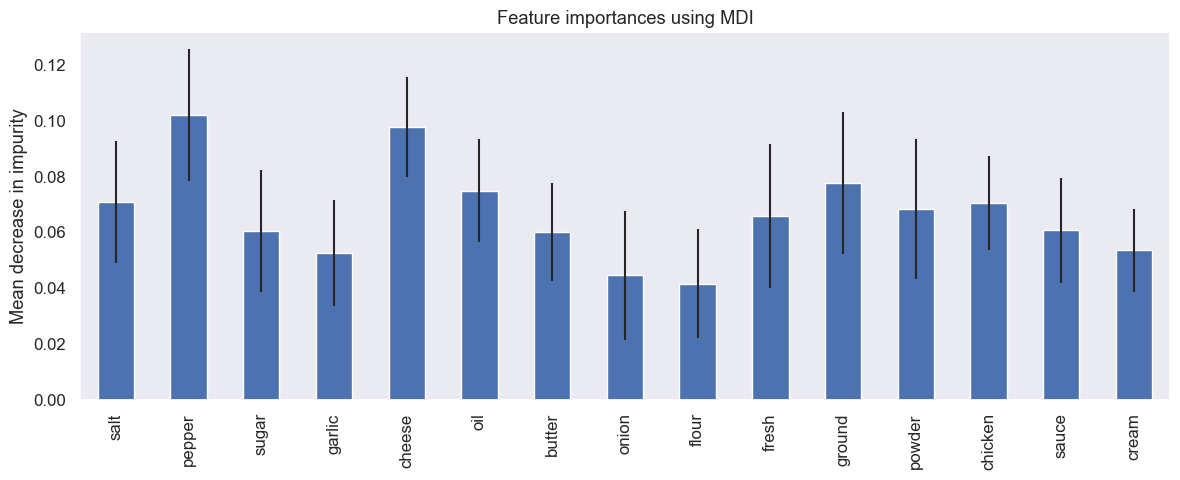

In [223]:
importances = forest.feature_importances_
feature_names = X_train.columns
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [230]:
perm = PermutationImportance(forest,random_state=42).fit(X_train,y_train)
exp = eli5.explain_weights(perm,feature_names=X_train.columns.tolist())
exp_df = eli5.format_as_dataframe(exp)

<AxesSubplot:title={'center':'Permutation importance'}, ylabel='feature'>

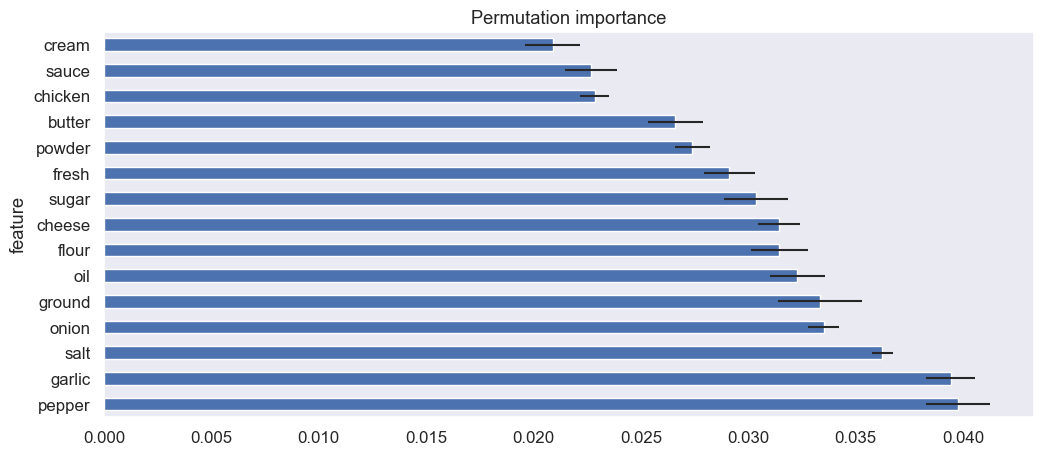

In [231]:
exp_df.plot(kind='barh',x='feature',y='weight',legend=False,title='Permutation importance',xerr ='std')

In [232]:
l_pdp_rfr = []

for feat in X_train.columns:
    print('Computing feature {}...'.format(feat))
    pdp_feat = pdp.pdp_isolate(model=forest,dataset=X_train,model_features=X_train.columns,feature=feat)
    l_pdp_rfr.append(pdp_feat)

Computing feature salt...
Computing feature pepper...
Computing feature sugar...
Computing feature garlic...
Computing feature cheese...
Computing feature oil...
Computing feature butter...
Computing feature onion...
Computing feature flour...
Computing feature fresh...
Computing feature ground...
Computing feature powder...
Computing feature chicken...
Computing feature sauce...
Computing feature cream...


<Figure size 1000x800 with 0 Axes>

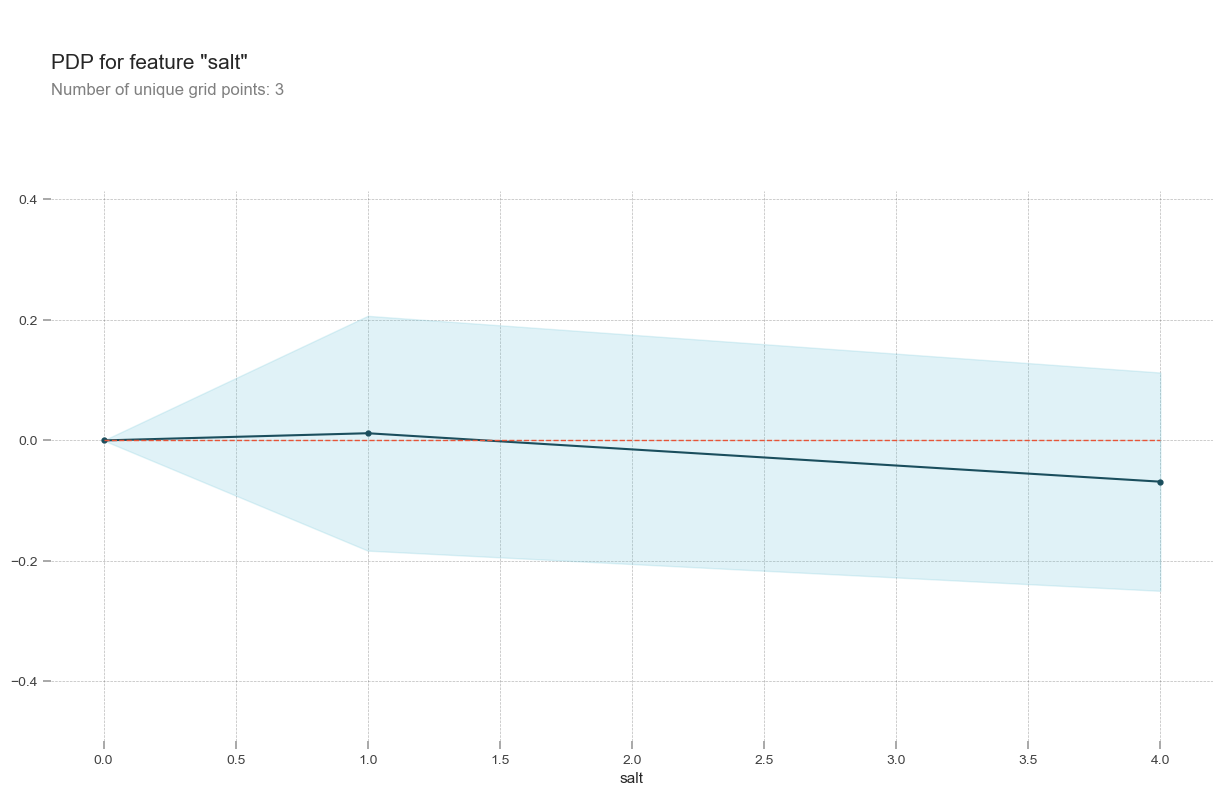

<Figure size 1000x800 with 0 Axes>

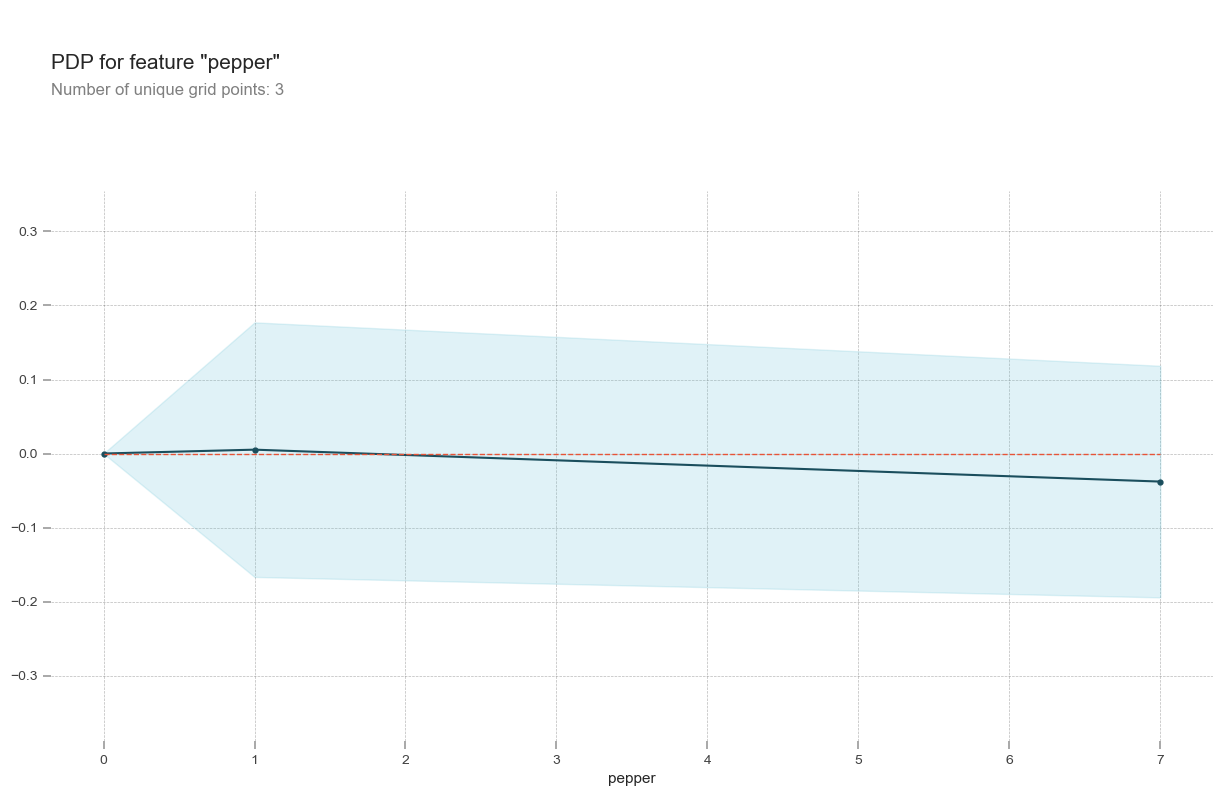

<Figure size 1000x800 with 0 Axes>

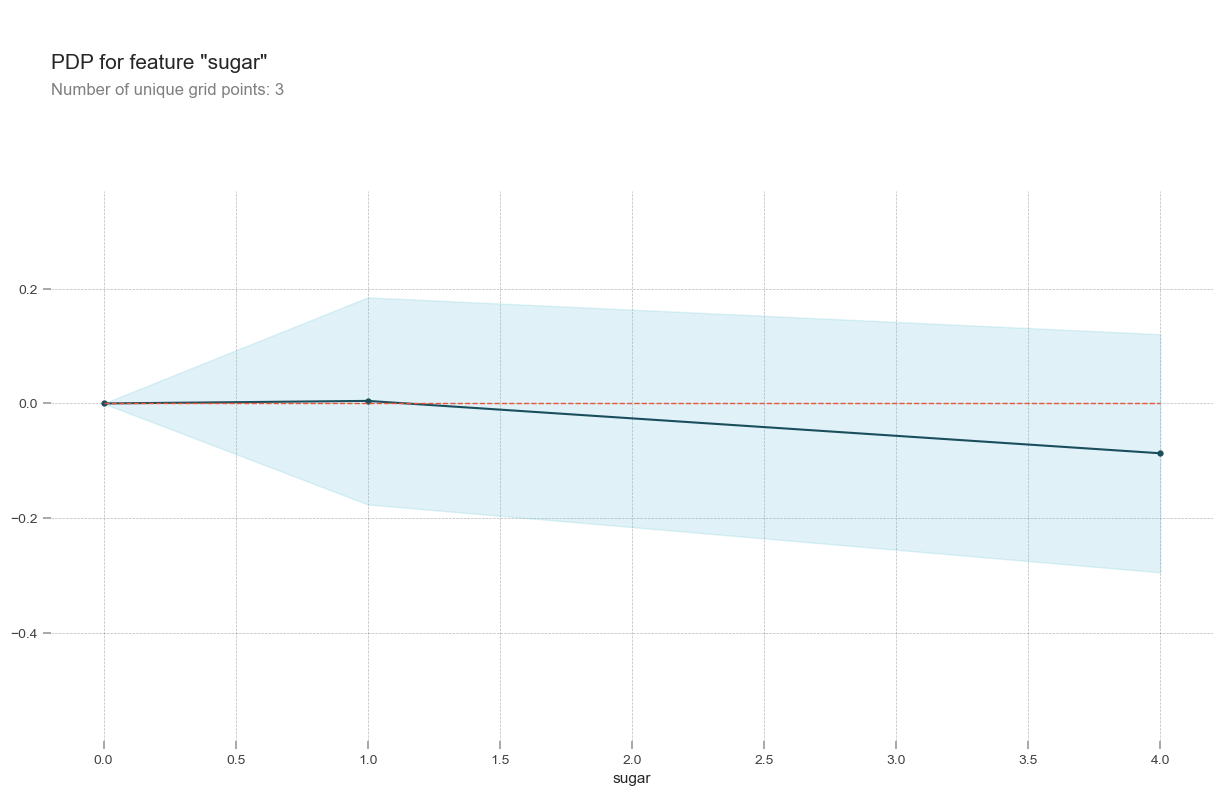

<Figure size 1000x800 with 0 Axes>

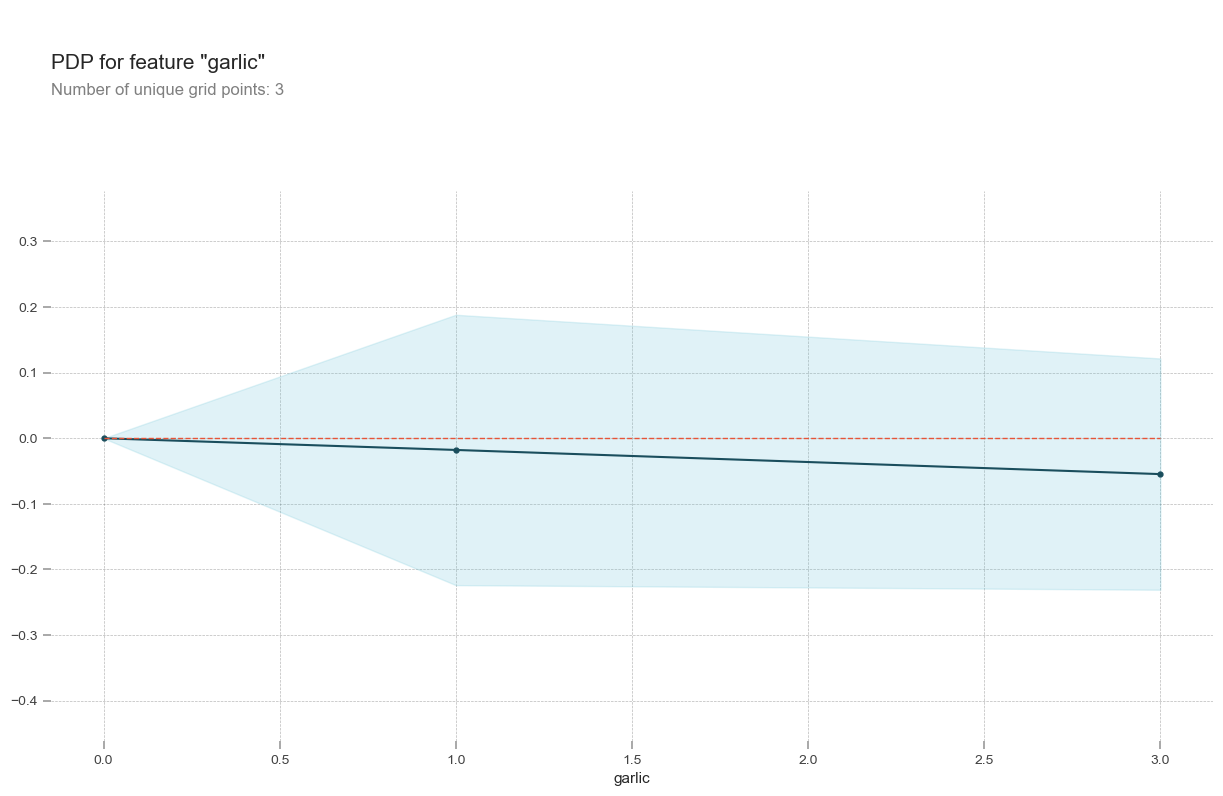

<Figure size 1000x800 with 0 Axes>

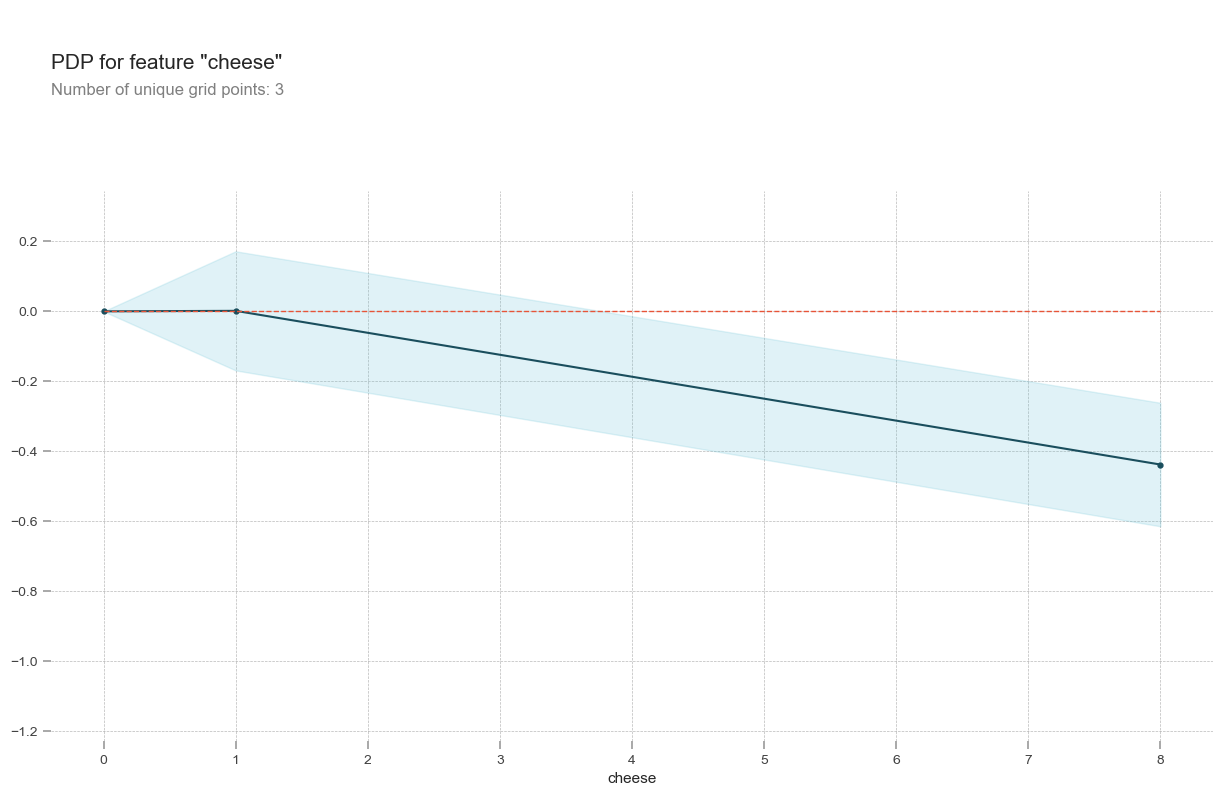

<Figure size 1000x800 with 0 Axes>

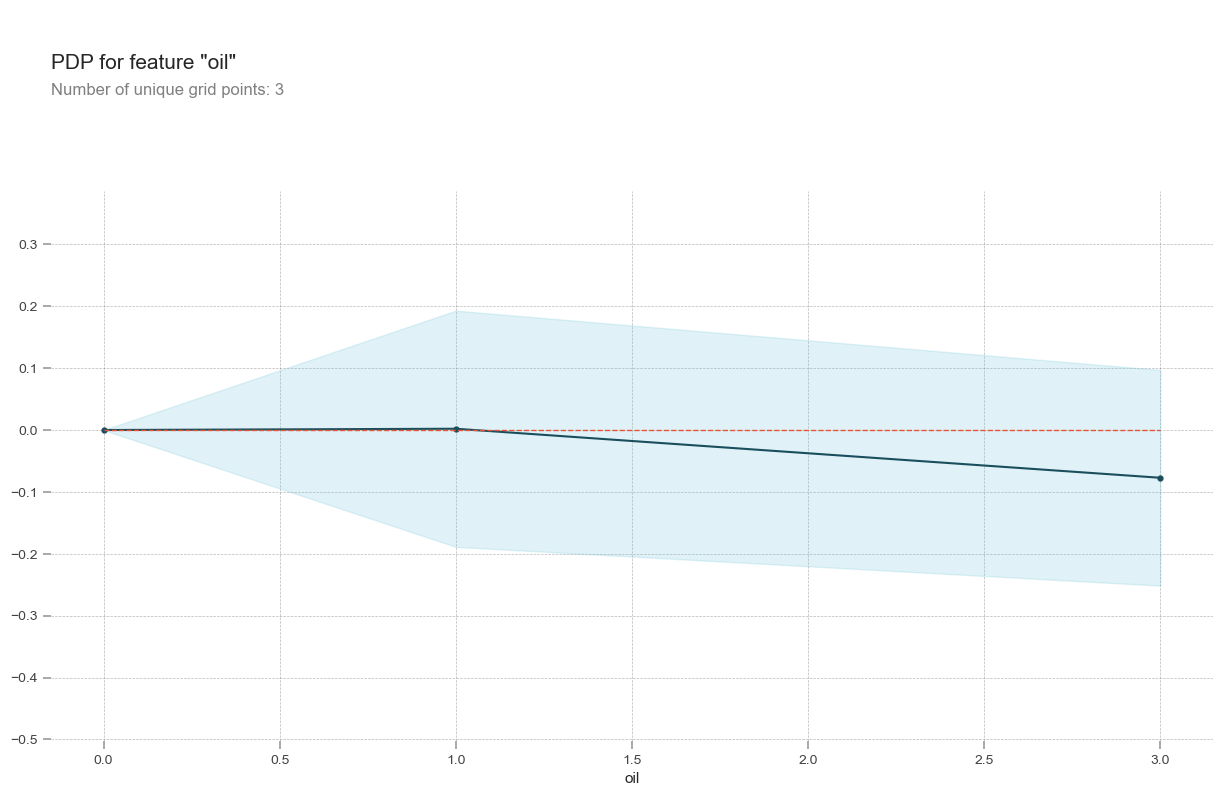

<Figure size 1000x800 with 0 Axes>

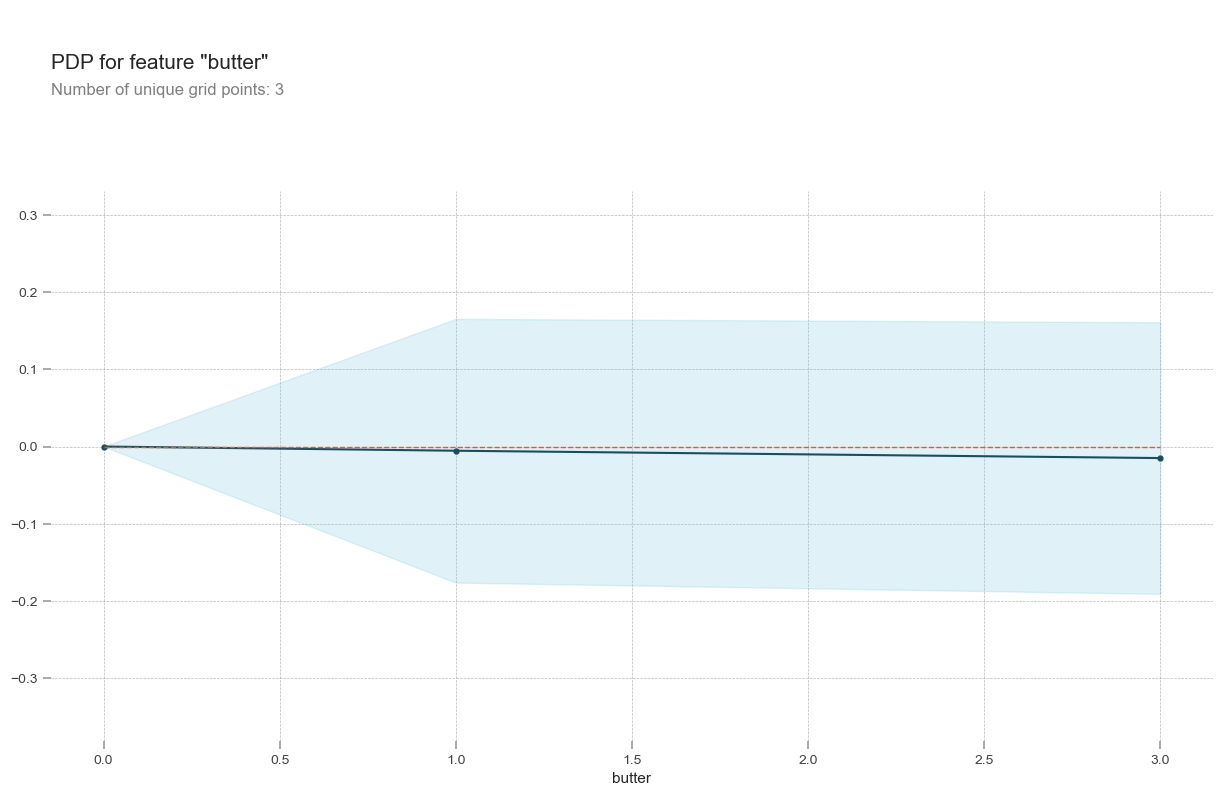

<Figure size 1000x800 with 0 Axes>

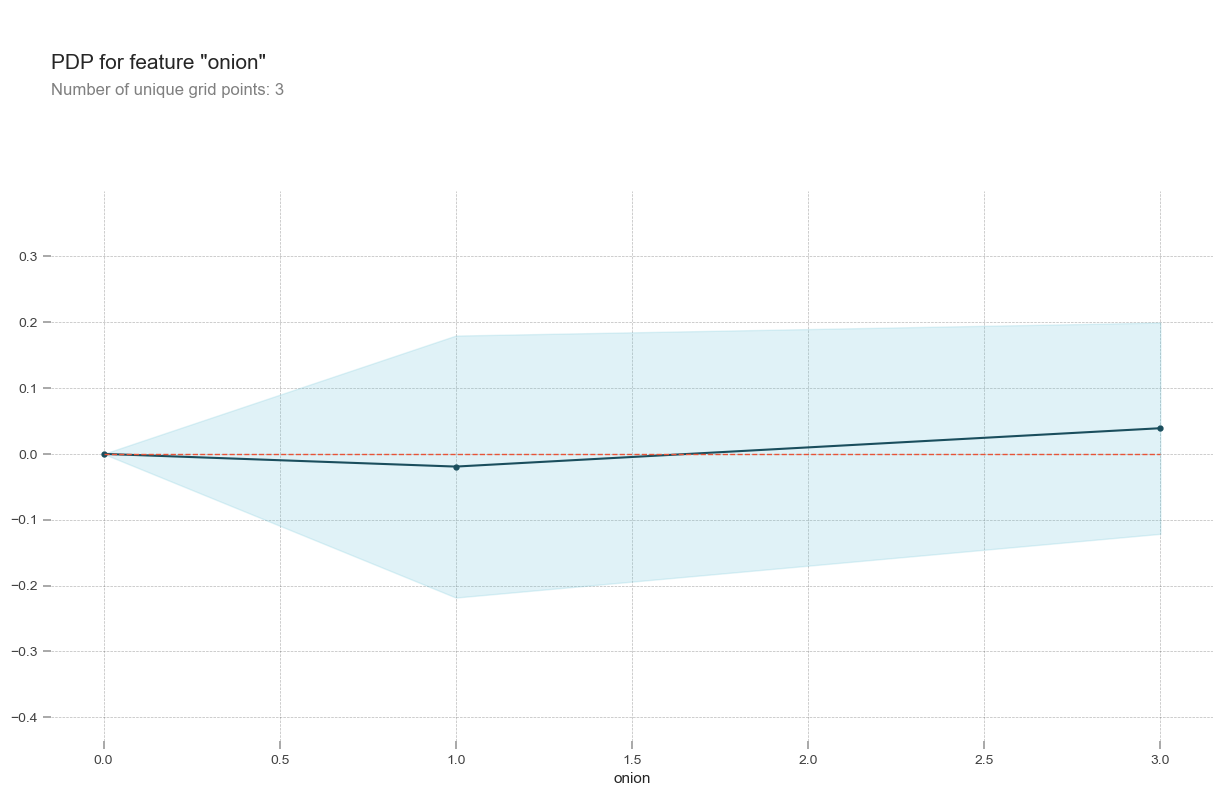

<Figure size 1000x800 with 0 Axes>

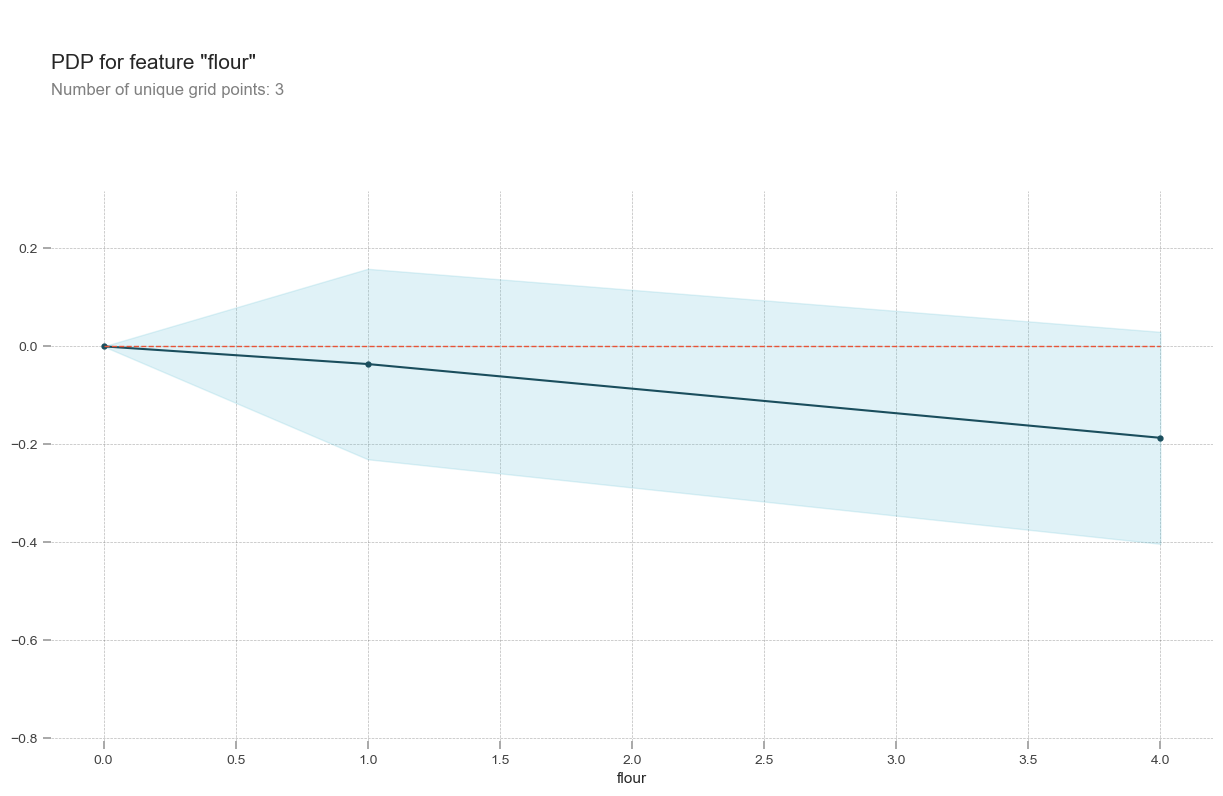

<Figure size 1000x800 with 0 Axes>

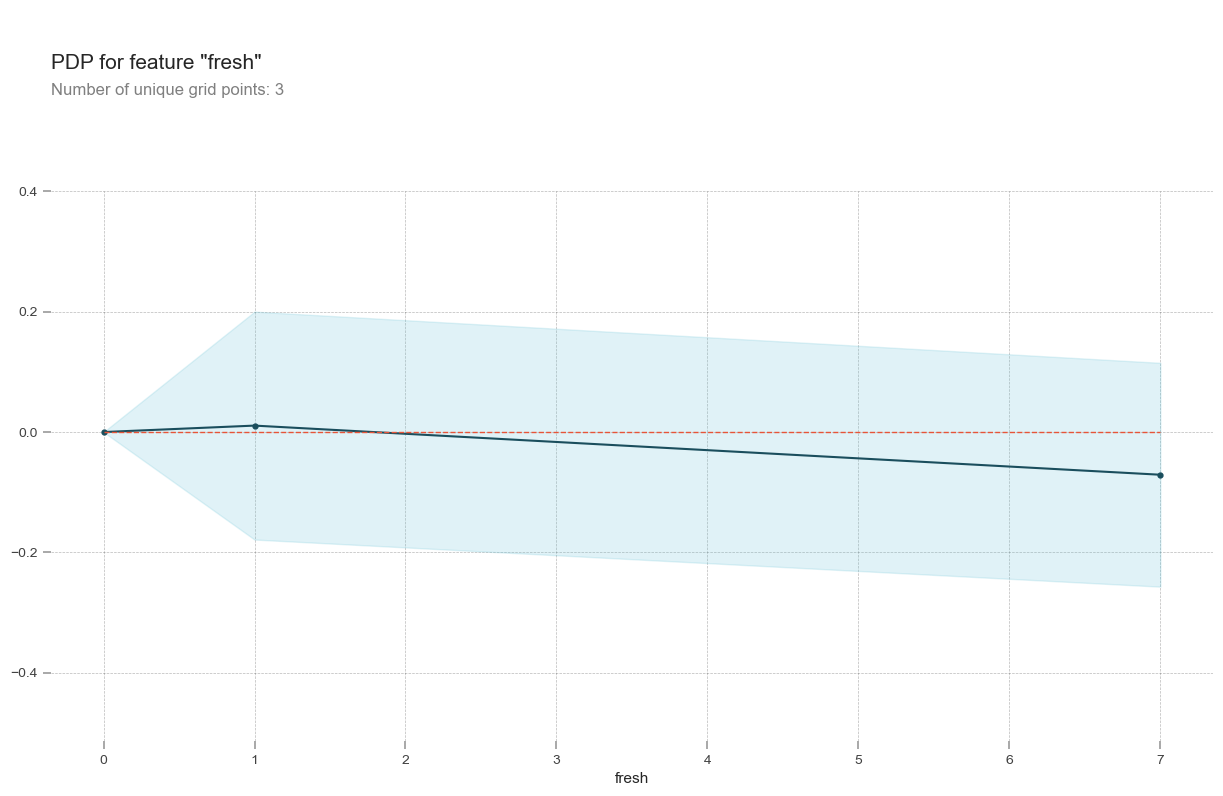

<Figure size 1000x800 with 0 Axes>

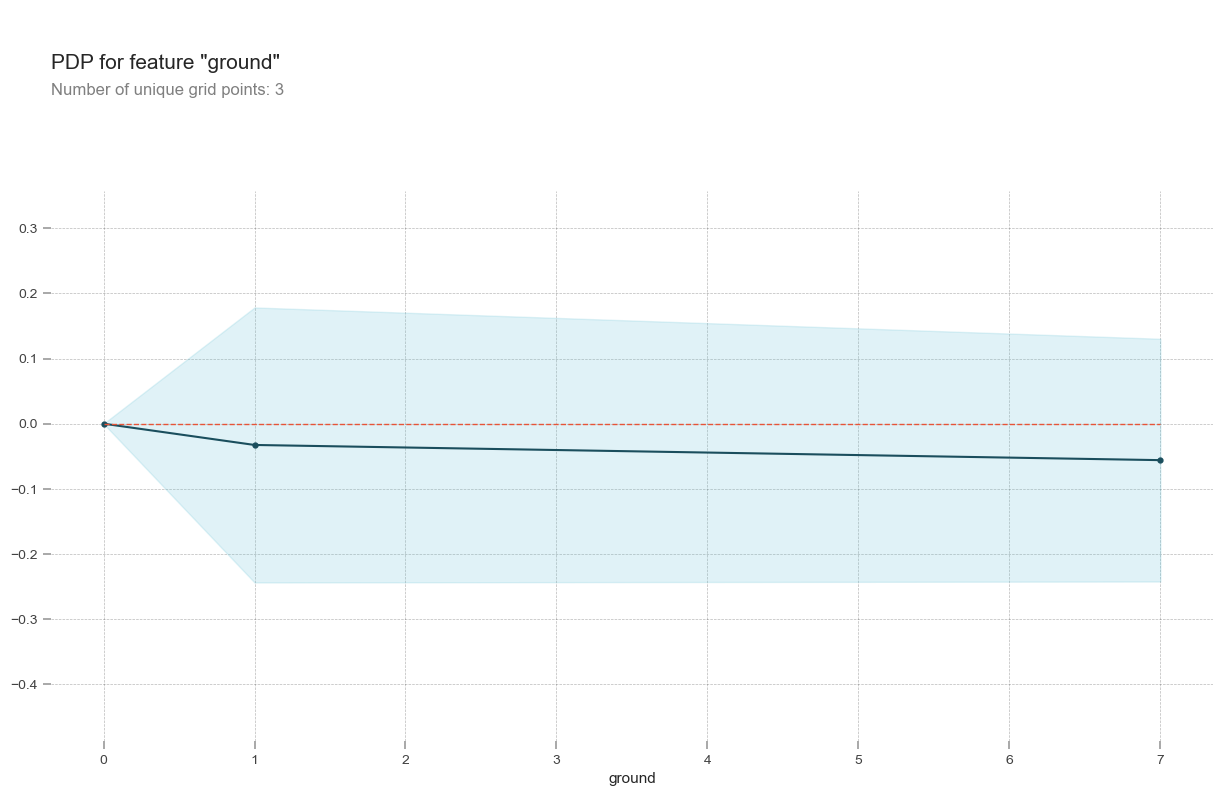

<Figure size 1000x800 with 0 Axes>

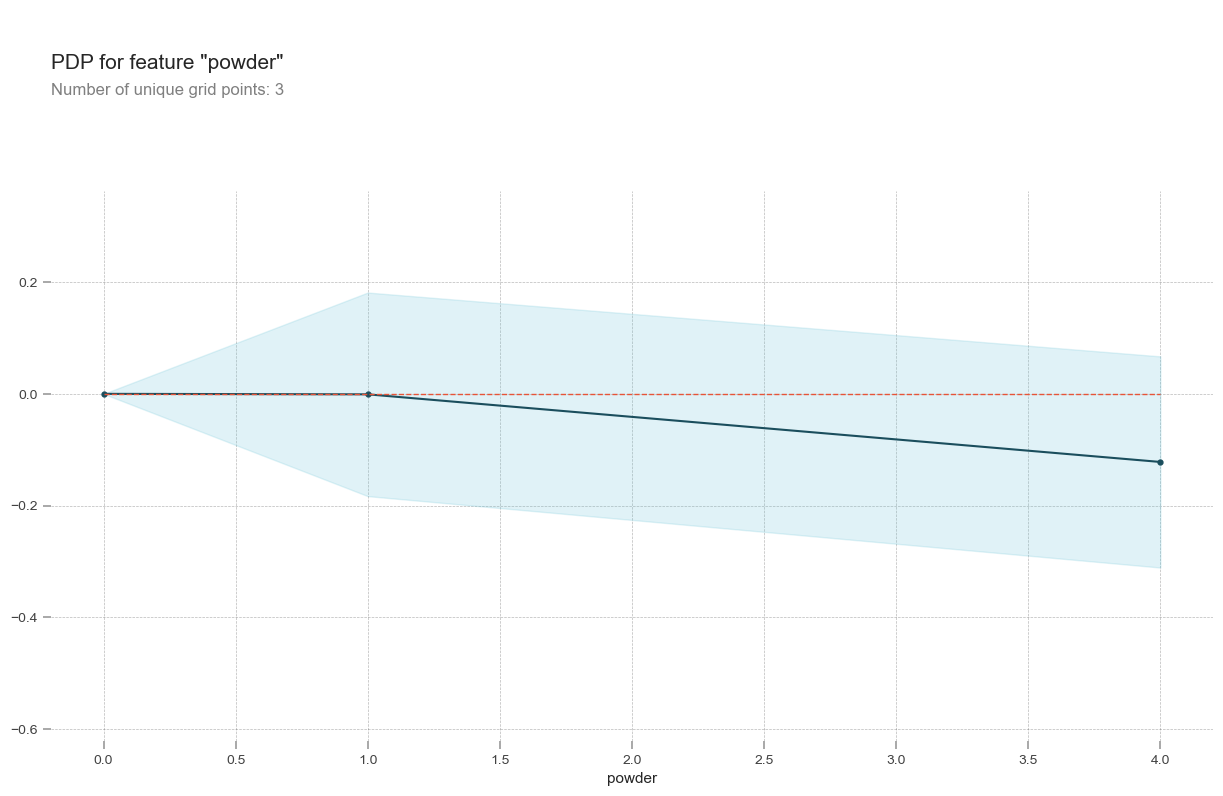

<Figure size 1000x800 with 0 Axes>

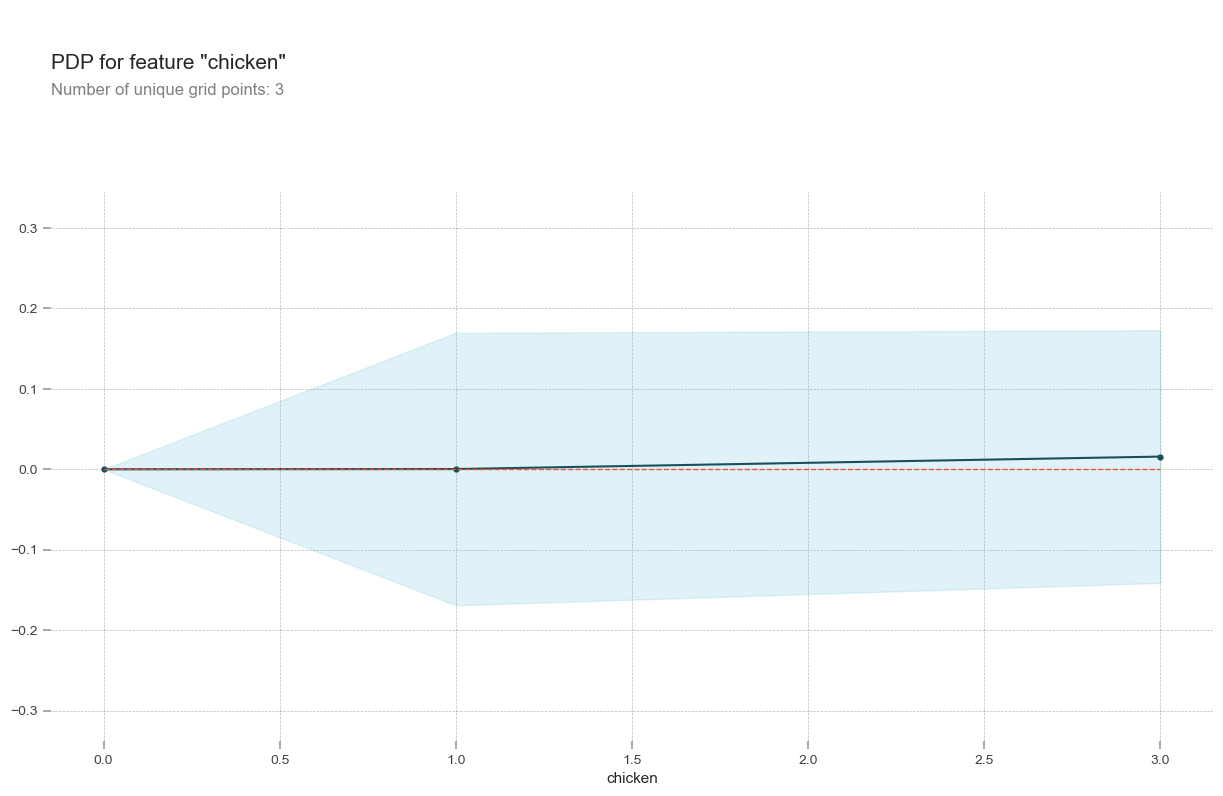

<Figure size 1000x800 with 0 Axes>

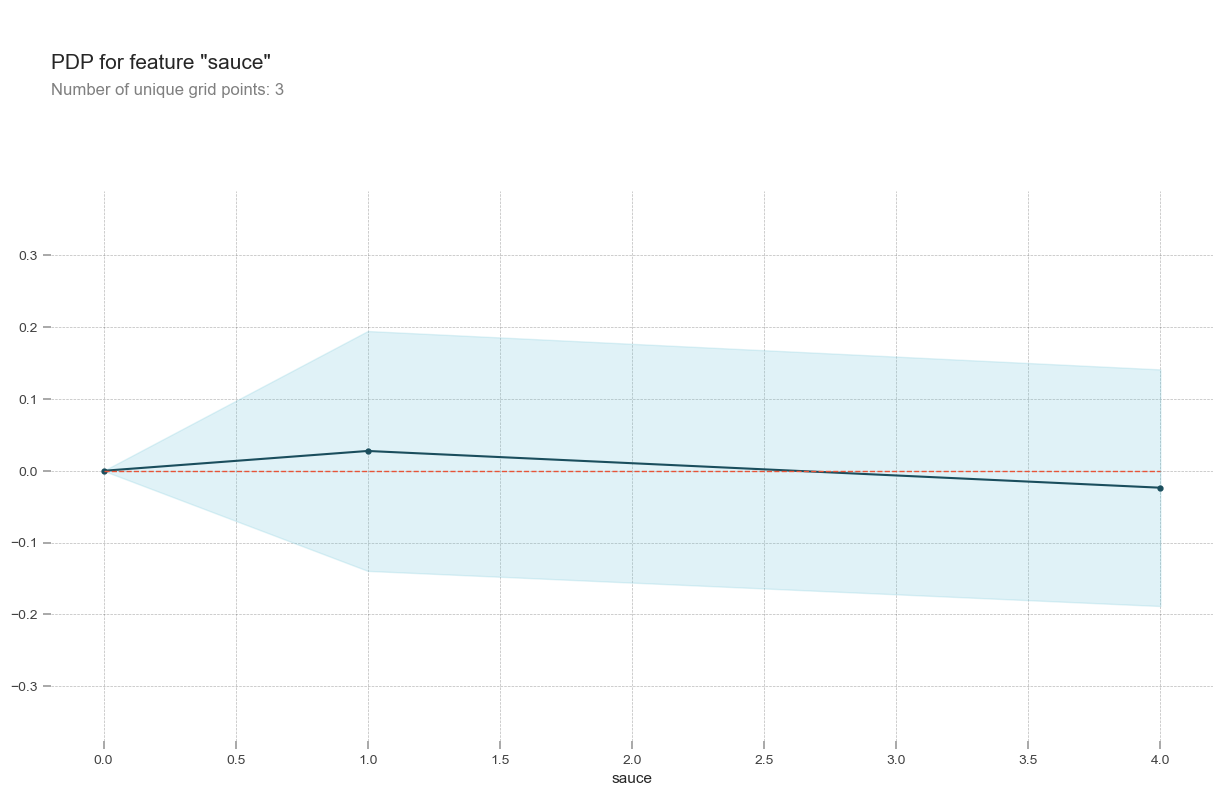

<Figure size 1000x800 with 0 Axes>

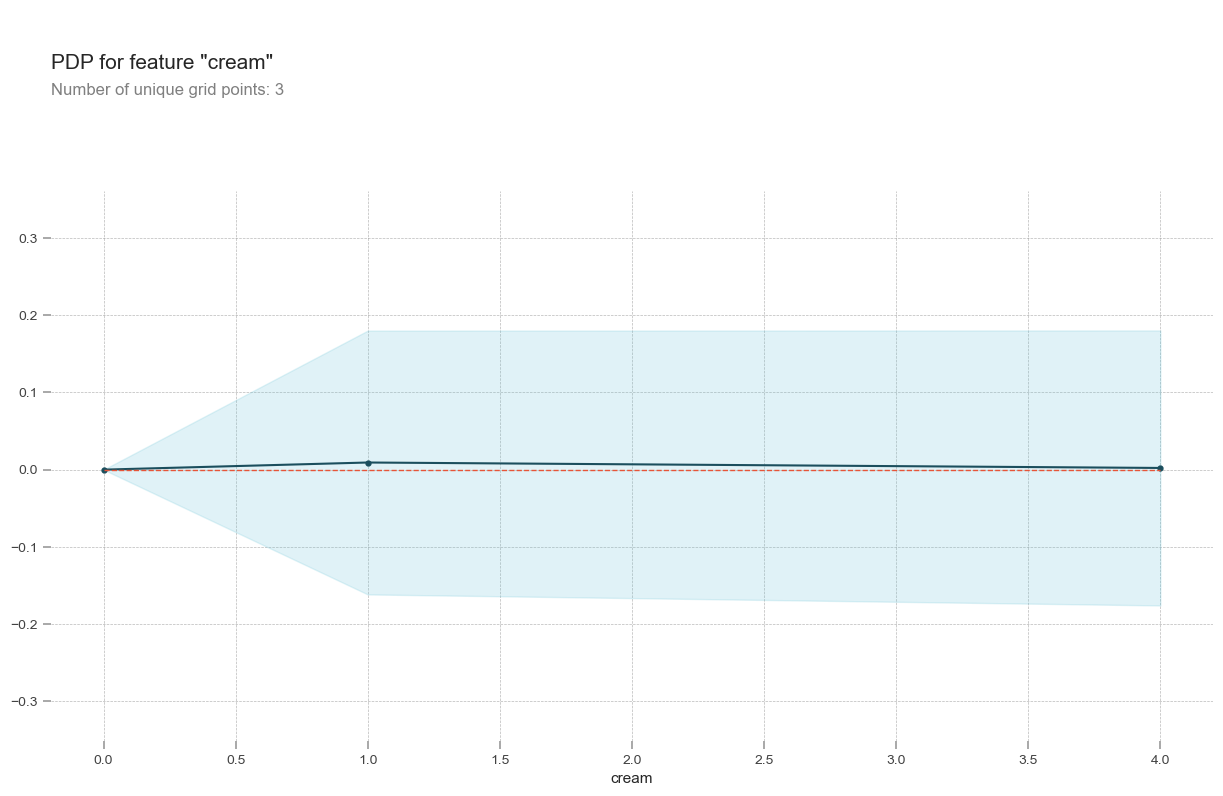

In [233]:
for i,pdp_feat in enumerate(l_pdp_rfr):
    fig = plt.figure(figsize=(10,8))
    pdp.pdp_plot(pdp_feat,X_test.columns[i])